Copyright 2024 Google, LLC. This software is provided as-is,
without warranty or representation for any use or purpose. Your
use of it is subject to your agreement with Google.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Gemini Chat with Image Output

This notebook provides a simple example for interacting with Google's Gemini models to generate inspirational images. For more info visit https://developers.googleblog.com/en/experiment-with-gemini-20-flash-native-image-generation/

Import python libraries

In [1]:
import asyncio
import base64
import contextlib
import datetime
import os
import json
import itertools
import yaml

import nest_asyncio

from IPython.display import Image, display, Markdown
from PIL import Image
from io import BytesIO

from google import genai
from google.genai import types


## Set variables for your environment 

For this example we are going to use AI Stuido. Create a Gemini API Key by going to https://aistudio.google.com/ and add it to the parameters.yaml file.

In [2]:
parameters_file = 'my_parameters.yaml'

In [3]:
with open(parameters_file, 'r') as f:
    parameters_data = yaml.safe_load(f)

In [4]:
#print(parameters_data['GeminiKey'])

We'll save the API key in the parameters.yaml file to the GEMINI_API_KEY variable.

In [5]:
GEMINI_API_KEY = parameters_data['GeminiKey']

Initialze the genai client using your API key.

In [6]:
client = genai.Client(api_key=GEMINI_API_KEY)

## Load a user's profile

Let's add a user's profile to this session. This information will help the model generate more personalized images based not only on supplied images, but also on key items such as past shopping history, items in cart, saved items, and more.

 We're going to use a file in this example, but this will most likely be pulled from an API in production. 

In [7]:
profile_file = 'user_profile.json'

In [8]:
with open (profile_file, 'r') as file:
    profile_data = file.read()

## Load an image and create a base64 encoded string

In [13]:
image_filename = 'disco-kitchen.jpg'

In [14]:
with open(image_filename, "rb") as f:
    encoded_base_image = base64.b64encode(f.read())
B64_BASE_IMAGE = encoded_base_image.decode('utf-8')

image_mime_type = "image/png"

## Initiate the session with user data, storyboards and desing ideas

Let's define the parameters for the chat session. We'll specify the model and response modalities here.

In [15]:
chat = client.chats.create(model="gemini-2.0-flash-exp-image-generation",
        config=types.GenerateContentConfig(
            response_modalities=["Text", "Image"]
        )
    )

At the time of this example, when using Image and Text outputs we can't directly set system instructions. With that in mind, we can initialize a the session with an initial prompt before performing the While loop for the chat session.

In [16]:
#sys_instruct=f'''
#1. Analyze the customer request to understand their intent and desired product.
#2. Ask ONLY 1-2 follow-up questions to clarify their style preferences.  These questions should be tailored to the customer's initial request and aim to gather information about preferred colors, materials, and overall aesthetic.
#3. Based on the customer's request and answers to the follow-up questions, generate a sample image of the product in a real-world environment. The image should be high-quality and professionally styled, as if taken by a professional photographer for a magazine.
#'''

In [17]:
#chat.send_message(sys_instruct)

Add the Inspiraiton image to the chat session

In [18]:
text_part = types.Part(text=f'''
You are a professional personal designer. You will receive an image from a customer and a description of their design request.  Your task is to analyze the provided storyboard to understand the customer's style preferences and then use those preferences to fulfill their design request.
Carefully examine the provided image. Consider elements such as color palettes, composition, use of textures, patterns, and overall aesthetic.  These elements will help your understanding of the customer's style and preferences.

In some cases, you will also received the user profile data. This profile includes items such as identified preferences, purchase history, items in cart, saved items, etc.

Based on the customer's request and answers to the follow-up questions, generate a sample image of the room in a stylish real-world environment. The image should be high-quality and professionally styled, as if taken by a professional photographer for a magazine.
Capture the full room in the image to help customers visualize the complete space and atmosphere. An image depicting the entire room allows customers to better grasp the overall look, feel, and layout.

Do NOT begin your conversation until you are instructed to do so.
''')


In [19]:
message_content = [text_part]

chat.send_message(message_content)

GenerateContentResponse(candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text="Okay, I understand. I'm ready to receive the image and design request to analyze the customer's style preferences and fulfill their new design request. I will ensure the generated image is a high-quality, professionally styled full room view consistent with their established taste.")], role='model'), citation_metadata=None, finish_message=None, token_count=None, finish_reason=<FinishReason.STOP: 'STOP'>, avg_logprobs=None, grounding_metadata=None, index=0, logprobs_result=None, safety_ratings=None)], create_time=None, response_id=None, model_version='gemini-2.0-flash-exp-image-generation', prompt_feedback=None, usage_metadata=GenerateContentResponseUsageMetadata(cache_tokens_details=None, cached_content_token_count=None, candidates_token_count=54,

Add the user profile to the session

In [20]:
text_part = types.Part(text=f'''
Here is the customer's profile data:
{profile_data}
''')


In [ ]:
message_content = [text_part]

chat.send_message(message_content)

Add the image to the session

In [21]:
text_part = types.Part(text=f'''
Here is an image of the customer's image. 
''')


In [22]:
image_part = types.Part(
    inline_data=types.Blob(
        mime_type=image_mime_type,
        data=B64_BASE_IMAGE
    )
)

In [23]:
message_content = [text_part, image_part]

chat.send_message(message_content)

GenerateContentResponse(candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text="The user has provided an image of a modern kitchen featuring handleless black and white cabinetry, a light wood island with black stools, light wood countertops, stainless steel appliances, a white farmhouse sink, and light grey wood-look flooring. The overall aesthetic is clean, minimalist, and contemporary with a neutral color palette accented by the wood tones and subtle greenery. I will use these elements to inform future design requests.\n\nPlease provide the customer's design request.")], role='model'), citation_metadata=None, finish_message=None, token_count=None, finish_reason=<FinishReason.STOP: 'STOP'>, avg_logprobs=None, grounding_metadata=None, index=0, logprobs_result=None, safety_ratings=None)], create_time=None, response_id=None, mo

## While loop for more advanced chat session

Now that we started the session with an initial prompt, we'll start a While loop for the interactive chat session.

In [24]:
tone = 'modern' # 'contemporary' 'budget' 'luxurious' 'modern' 'minimalist'
room = 'kitchen' # 'home office' 'living room' 'nursery' 'kitchen'
mood = 'relaxing' # 'creativity' 'relaxing' 'productivity' 'energy'
accents = 'subtle' # 'subtle' 'bold' 'natural' 
color = 'warm' # 'warm' 'cool'

Generating visual inspiration for your room makeover. Please wait...
--------------------
Model (Text Part): Hello! Based on your desire for a relaxing, modern kitchen with subtle accents and warm colors, here is an initial concept.


--------------------


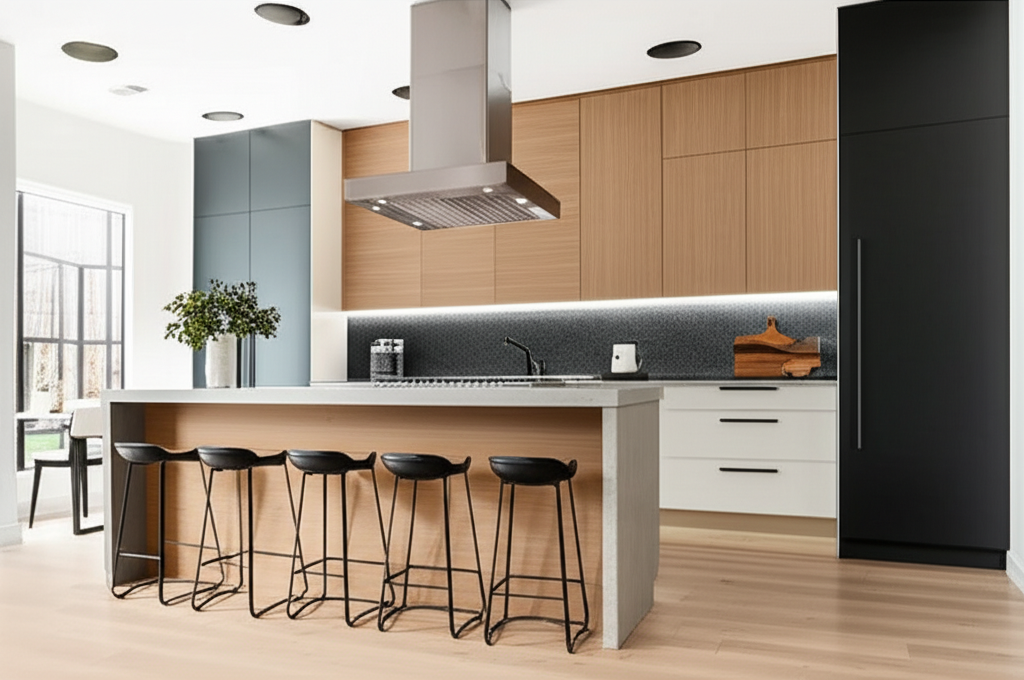

--------------------
Model (Text Part): 
This design incorporates warm wood-toned cabinetry, a light grey quartz countertop on the island with black bar stools, a subtle blue accent wall with matching lower cabinets, and light wood flooring to create a modern yet relaxing atmosphere.
--------------------
--------------------


Enter your prompt here (or 'End' to quit):  Change the stools to white


--------------------


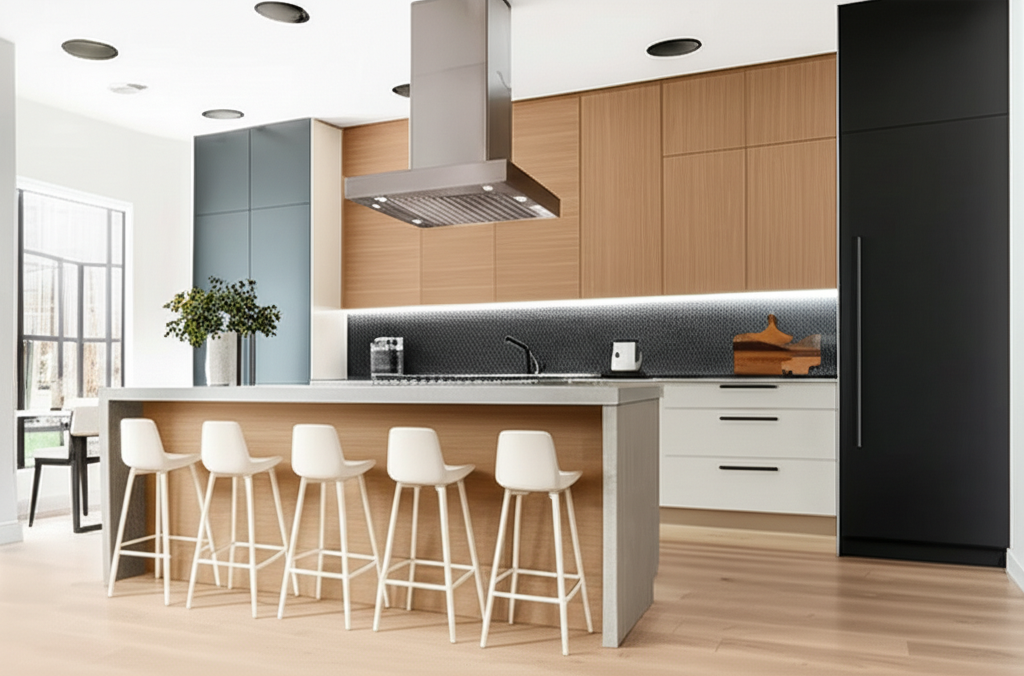

--------------------


Enter your prompt here (or 'End' to quit):  end


--------------------
Chat ended.


In [25]:
print("Generating visual inspiration for your room makeover. Please wait..." )
print("-" * 20)


response = chat.send_message(f'''
You may now start your conversation. 
Begin with a professional greeting and generate an initial image as a starting point.
Keep your summary short and to the point.

I want to design a {room} for a {mood} feel with {accents} accents and {color} colors. I want the tone of the room to be {tone}.
''')

# --- Corrected Image and Text Handling ---
if response.candidates and response.candidates[0].content:
    # Iterate through ALL parts in the response
    for part in response.candidates[0].content.parts:
        if part.text:  # Check if the part has text
            print("Model (Text Part):", part.text)
            print("-" * 20)

        if part.inline_data:  # Check if the part has inline_data (image)
            try:
                byte_stream = BytesIO(part.inline_data.data)
                gen_image = Image.open(byte_stream)  # Open directly
                # gen_image = gen_image.convert("RGB")  # Only convert if you DON'T want alpha
                display(gen_image)
                print("-" * 20)
            except Exception as e:
                print(f"Error displaying image: {e}")
else:
     print("No candidates or content found in the response.")
print("-" * 20)

while True:
    user_input = input("Enter your prompt here (or 'End' to quit): ")
    print("-" * 20)

    if user_input.lower() == "end":
        print("Chat ended.")
        break

    try:
        response = chat.send_message(user_input)

        # Good practice: write the FULL response to a file for debugging
        #with open("my_file.txt", "w") as file:
            #file.write(str(response))

        # --- Corrected Image and Text Handling ---
        if response.candidates and response.candidates[0].content:
            # Iterate through ALL parts in the response
            for part in response.candidates[0].content.parts:
                if part.text:  # Check if the part has text
                    print("Model (Text Part):", part.text)
                    print("-" * 20)

                if part.inline_data:  # Check if the part has inline_data (image)
                    try:
                        byte_stream = BytesIO(part.inline_data.data)
                        gen_image = Image.open(byte_stream)  # Open directly
                        # gen_image = gen_image.convert("RGB")  # Only convert if you DON'T want alpha
                        display(gen_image)
                        print("-" * 20)
                    except Exception as e:
                        print(f"Error displaying image: {e}")
        else:
             print("No candidates or content found in the response.")
    except Exception as e:
        print(f"An error occurred: {e}")
        break

## Save the image for Visual Image Search

In [26]:
gen_image.save('output.jpg')

## Chat History Analysis

In [ ]:
chat_history = ""
for message in chat.get_history():
    chat_history += f"role - {message.role}: {message.parts[0].text}\n"

In [ ]:
chat_review = client.models.generate_content(
    model="gemini-2.0-flash-exp",
    contents=(
        "Review the following chat history. Identify the user's intent and style preference. Provide an overview of the interaction and overall sentiment from the user. Chat History: "+chat_history
    ),
    config=types.GenerateContentConfig(
        response_modalities=["Text", "Image"]
    ),
)

In [ ]:
#print(chat_review.text)
display(Markdown(chat_review.text))